In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import snf

In [2]:
rnamat = pd.read_csv('../matrices/gene_exp_matrix.tsv.gz',sep='\t')
cnmat = pd.read_csv('../matrices/gene_cn_matrix.tsv.gz',sep='\t')
gfmat = pd.read_csv('../matrices/gene_fusion_matrix.tsv',sep='\t')
mutmat = pd.read_csv('../matrices/gene_mut_matrix_gt1.tsv.gz',sep='\t')

Standard normalization on the numeric columns

In [3]:
def stdNormalization(df):
    numeric_df = df.select_dtypes(include=[np.number])
    std = numeric_df.std().fillna(1)
    mean = numeric_df - numeric_df.mean()
    numeric_df_norm = mean / std
    nonnumeric_df = df.select_dtypes(exclude=[np.number])
    df_norm = pd.concat([nonnumeric_df, numeric_df_norm], axis=1)
    return df_norm

In [4]:
rnamat_s = stdNormalization(rnamat)
rnamat_s.shape

(806, 18627)

In [35]:
cnmat_s = stdNormalization(cnmat)
cnmat_s.shape

(924, 18789)

Remove singleton features

In [31]:
gfmat_s = gfmat.set_index(['PUBLIC_ID', 'SAMPLE']).loc[:, gfmat.set_index(['PUBLIC_ID', 'SAMPLE']).sum(axis=0) >= 2].reset_index()
gfmat_s = stdNormalization(gfmat_s)
gfmat_s.shape

(798, 551)

In [32]:
mutmat_s = mutmat.set_index(['PUBLIC_ID', 'SAMPLE']).loc[:,mutmat.set_index(['PUBLIC_ID', 'SAMPLE']).sum(axis=0) >= 2].reset_index()
mutmat_s = stdNormalization(mutmat_s)
mutmat_s.shape

(974, 10566)

In [34]:
common_samples = \
    set(rnamat[['PUBLIC_ID', 'SAMPLE']].apply(tuple, axis=1)).intersection(
    set(cnmat[['PUBLIC_ID', 'SAMPLE']].apply(tuple, axis=1)),
    set(gfmat[['PUBLIC_ID', 'SAMPLE']].apply(tuple, axis=1)),
    set(mutmat[['PUBLIC_ID', 'SAMPLE']].apply(tuple, axis=1))
)
len(common_samples)

650

In [9]:
dataset = [
    mat[mat[['PUBLIC_ID', 'SAMPLE']].apply(tuple, axis=1).isin(common_samples)].set_index(['PUBLIC_ID', 'SAMPLE']).astype(float) # snf needs it in float dtype
    for mat in [rnamat_s, cnmat_s, mutmat_s, gfmat_s]
]

In [10]:
for arr in dataset:
    print (arr.shape)

(650, 18625)
(650, 18787)
(650, 10564)
(650, 549)


Make individual networks (using all available samples)

In [8]:
gene_exp_network = snf.make_affinity(rnamat_s.select_dtypes(include=[np.number]), metric='euclidean', K=20, mu=0.5)

/home/jiageng/Documents/fhr/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jiageng/Documents/fhr/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [14]:
gene_exp_network_out = pd.DataFrame(gene_exp_network, columns = rnamat_s.PUBLIC_ID, index=rnamat_s.PUBLIC_ID)
gene_exp_network_out.to_csv('../matrices/adjacency/gene_exp_network.tsv',sep='\t')

Make individual networks using common samples

In [37]:
affinity_network = snf.make_affinity(dataset, metric='euclidean', K=20, mu=0.5)

/home/jiageng/Documents/fhr/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jiageng/Documents/fhr/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jiageng/Documents/fhr/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jiageng/Documents/fhr/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jiageng/Documents/fhr/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finit

In [38]:
fused_network = snf.snf(affinity_network, K=20)

/home/jiageng/Documents/fhr/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jiageng/Documents/fhr/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jiageng/Documents/fhr/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jiageng/Documents/fhr/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [52]:
pd.DataFrame(affinity_network[0],index = pd.Index(common_samples), columns = pd.Index(common_samples)).to_csv('../matrices/adjacency/gene_exp_network.tsv',sep='\t')

In [53]:
pd.DataFrame(affinity_network[1],index = pd.Index(common_samples), columns = pd.Index(common_samples)).to_csv('../matrices/adjacency/gene_cn_network.tsv',sep='\t')

In [54]:
pd.DataFrame(affinity_network[2],index = pd.Index(common_samples), columns = pd.Index(common_samples)).to_csv('../matrices/adjacency/gene_mut_network.tsv',sep='\t')

In [55]:
pd.DataFrame(affinity_network[3],index = pd.Index(common_samples), columns = pd.Index(common_samples)).to_csv('../matrices/adjacency/gene_fusion_network.tsv',sep='\t')

In [50]:
pd.DataFrame(fused_network,index = pd.Index(common_samples), columns = pd.Index(common_samples)).to_csv('../matrices/adjacency/fused_network.tsv',sep='\t')

Visualize the fused network

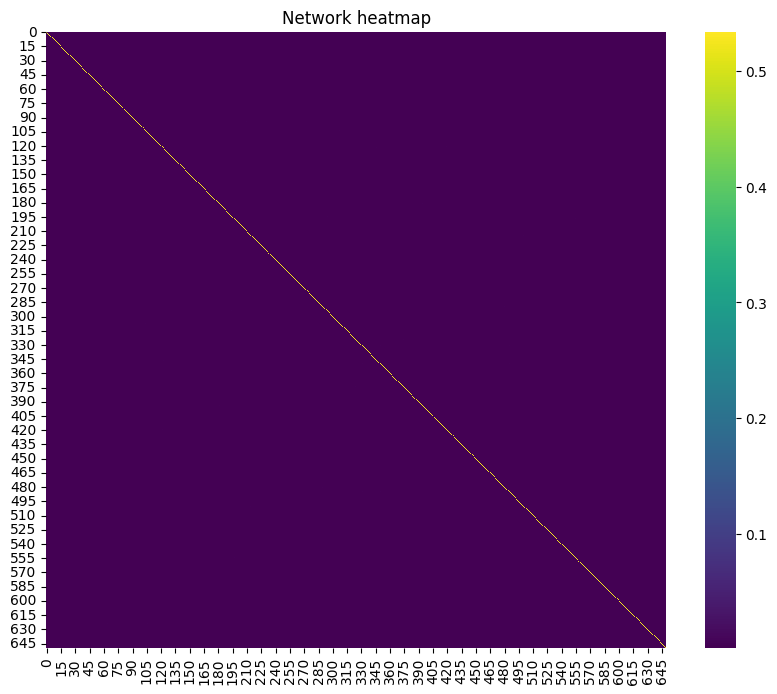

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(fused_network, cmap='viridis')
plt.title('Network heatmap')
plt.show()
# plt.savefig('../assets/network_heatmap.png')

In [40]:
best, second = snf.get_n_clusters(fused_network)
best, second

(np.int64(3), np.int64(4))

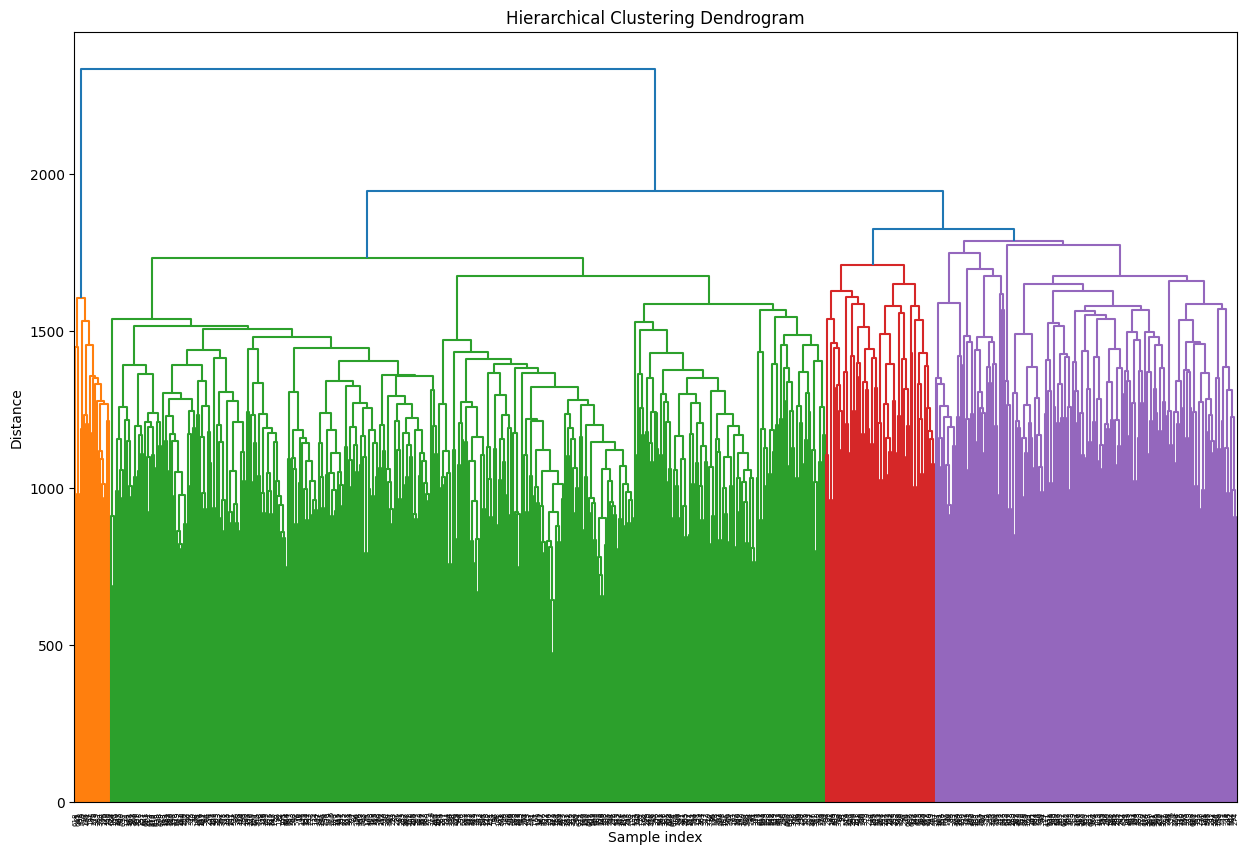

In [56]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Perform hierarchical clustering
Z = linkage(1/fused_network, method='average')

# Plot the dendrogram
plt.figure(figsize=(15, 10))
dendrogram(Z,color_threshold = 1800)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()